In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from xgboost import plot_tree
from sklearn.model_selection import train_test_split


In [377]:
# def create_features(df):
#     df = df.copy()
#     df['minute'] =df.index.minute
#     df['hour'] = df.index.hour
#     df['dayofweek']=df.index.dayofweek
#     df['quarter']=df.index.quarter
#     df['month']=df.index.month
#     return df
def create_features(df):
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    
    # Sine and cosine transformations for cyclic features
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [378]:
def add_lags(df):
    target_map = df['oxygenValue'].to_dict()
    df['lag_1']=(df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 day')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 day')).map(target_map)
    return df

In [379]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)

In [380]:
tss = TimeSeriesSplit(n_splits=8, test_size=60*24*30, gap=60*24)
df = df.sort_index()

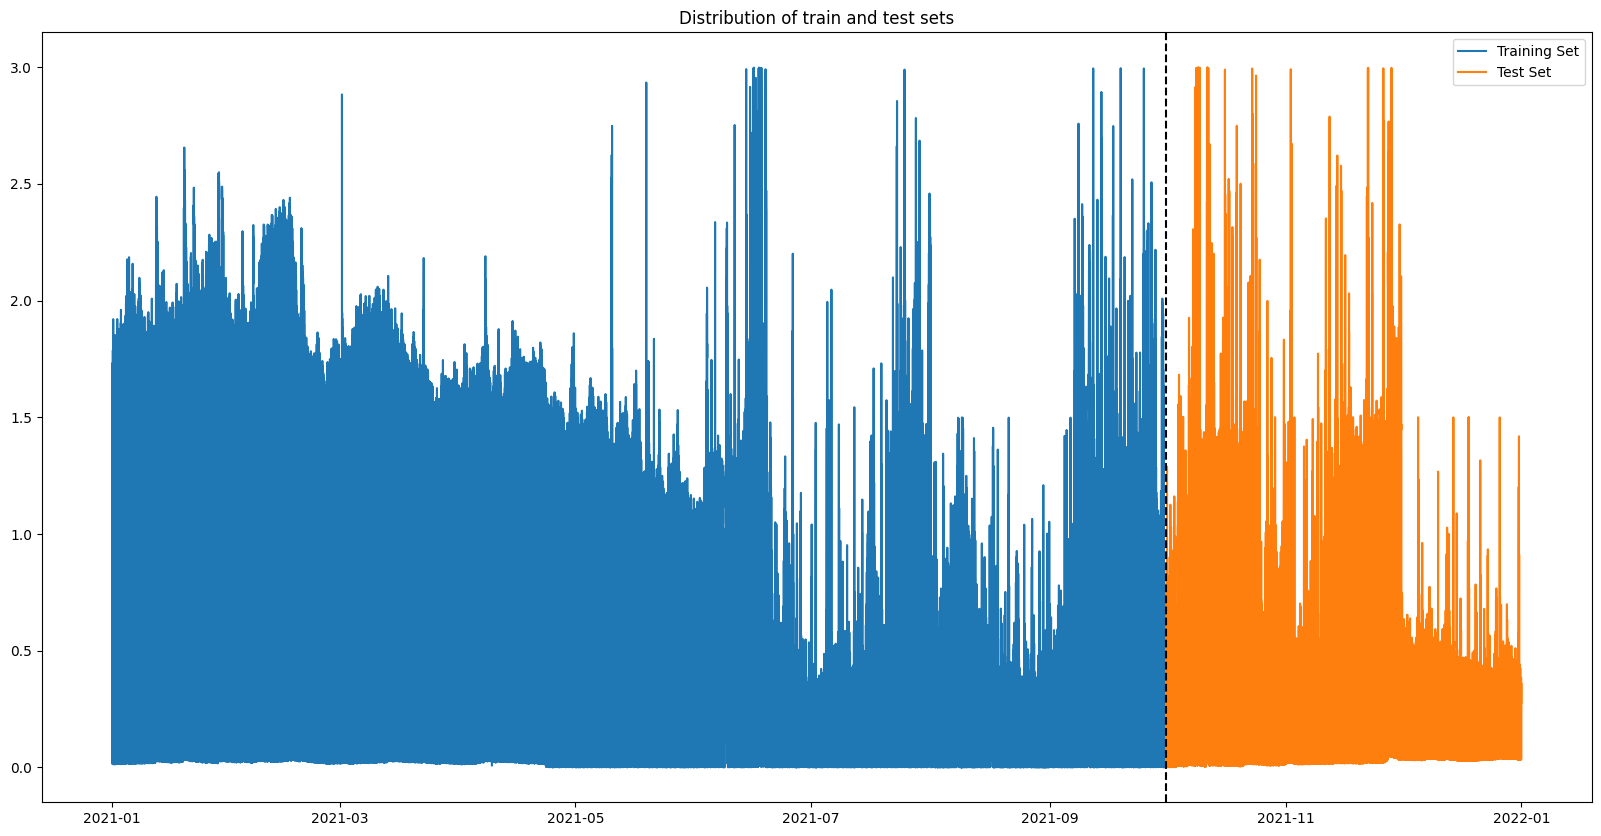

In [381]:
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train.index,train['oxygenValue'])
plt.plot(test.index,test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

In [382]:
FEATURES = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
            'waterFlowPerMinute', 'precipitation', 'minute_sin', 'minute_cos',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
            'quarter_sin', 'quarter_cos', 'month_sin', 'month_cos',
            'lag_1', 'lag_2', 'lag_3']
# FEATURES= ['nitrateValue', 'phosphateValue', 'ammoniumValue',
#        'waterFlowPerMinute', 'precipitation', 'minute', 'hour', 'dayofweek',
#        'quarter', 'month', 'lag_1', 'lag_2', 'lag_3']
TARGET = 'oxygenValue'

df = create_features(df)
df= add_lags(df)
df.dropna()
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']
X_train_data, y_train_data = train[FEATURES],train[FEATURES]
X_test_data, y_test_data = test[FEATURES],test[FEATURES]

KeyError: 'minute'

In [ ]:
scaler = StandardScaler()
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.transform(X_test_data)

In [ ]:
fold = 0
preds =[]
scores =[]
r2_scores = []
mae_scores = []

# paramsRF = {
#     'n_estimators': 100,
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'subsample': 0.8,
#     'colsample_bynode': 0.8,
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
#     'gamma': 0,
#     'reg_alpha': 0,
#     'reg_lambda': 1
# }

paramsRF = {
  "colsample_bynode": 1,
  "learning_rate":1,
  "max_depth": 9,
  "num_parallel_tree": 150,
  "objective": "reg:squarederror",
  "subsample": 0.9,
  "tree_method": "hist",
  "device": "cuda"
}





for train_idx, val_idx in tss.split(X_train_data):
    train= df.iloc[train_idx]
    test = df.iloc[val_idx]

    train= create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRFRegressor(**paramsRF)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1)
    fold+=1

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test,y_pred)
    scores.append(score)
    r2= r2_score(y_test,y_pred)
    r2_scores.append(r2)
    mae = mean_absolute_error(y_test,y_pred)
    mae_scores.append(mae)


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.55476	validation_1-rmse:0.78322


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.61311	validation_1-rmse:0.63895


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.59686	validation_1-rmse:0.61131


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.57147	validation_1-rmse:0.56261


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.54579	validation_1-rmse:0.77714


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.53157	validation_1-rmse:0.56101


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.51877	validation_1-rmse:0.29962


/tmp/ipykernel_50957/1599983229.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.index.minute
/tmp/ipykernel_50957/1599983229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_50957/1599983229.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

[0]	validation_0-rmse:0.49716	validation_1-rmse:0.55378


In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

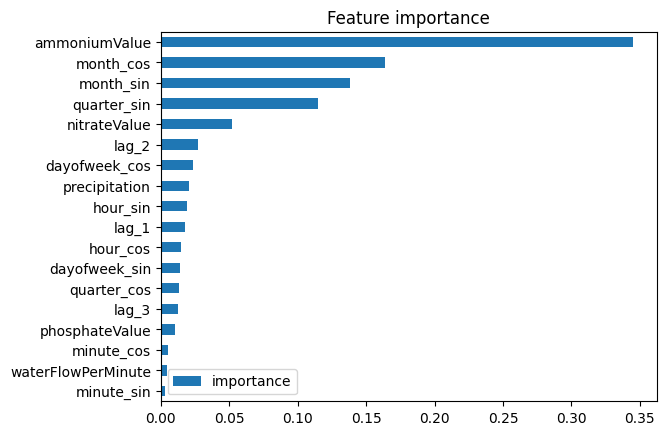

In [ ]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [ ]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')
print(f'R2 score across the folds:  {np.mean(r2_scores):0.4f}')
#print(f'Fold R2 scores: {r2_scores}')
print(f'Mean Absolute Error: {np.mean(mae_scores):0.4f}')
print(f'Mean Absolute Errors per fold: {mae_scores}')

Score across folds: 0.5985
Fold scores: [0.7832171470893079, 0.6389531157854734, 0.6113135798689483, 0.5626061642113357, 0.7771389486880508, 0.5610055429586596, 0.2996226346122034, 0.5537775672115137]
R2 score across the folds:  -0.1190
Mean Absolute Error: 0.4473
Mean Absolute Errors per fold: [0.6725401802590378, 0.512694463410234, 0.4534829839432018, 0.36107473149000496, 0.5652262252386632, 0.39186571097157624, 0.20417088367491407, 0.41702180975570174]


In [ ]:
HYPER_PARAMETERS_DF: pd.DataFrame

try:
   HYPER_PARAMETERS_DF =  pd.read_csv('hyperParameters.csv')
except:
	HYPER_PARAMETERS_DF = pd.DataFrame(columns=["colsample_bynode", "learning_rate", "max_depth", 
                                    "num_parallel_tree", "objective", "subsample", 
                                    "tree_method", "device", "MAE", "RMSE"])

new_row = pd.DataFrame([paramsRF])
HYPER_PARAMETERS_DF = pd.concat([HYPER_PARAMETERS_DF, new_row], ignore_index=True)
HYPER_PARAMETERS_DF['MAE'] = np.mean(mae_scores)
HYPER_PARAMETERS_DF['RMSE'] = np.mean(scores)

HYPER_PARAMETERS_DF.to_csv('hyperParameters.csv', index=False)

In [ ]:

y_test_data['prediction'] = reg.predict(X_test_data)
df= df.merge(y_test_data[['prediction']],how='left',left_index=True,right_index=True)

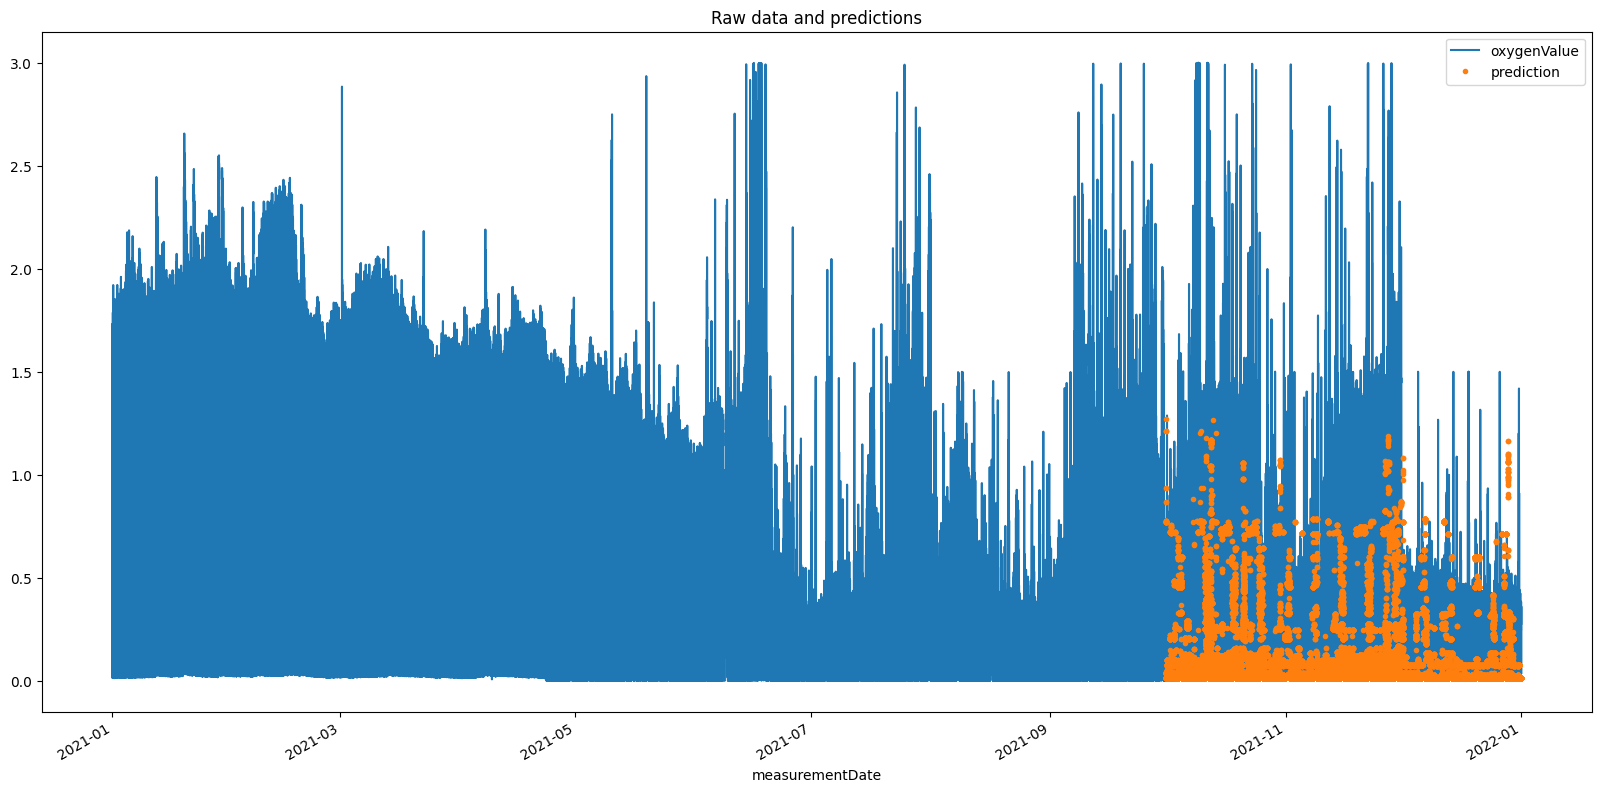

In [ ]:
ax = df[['oxygenValue']].plot(figsize=(20,10))
df['prediction'].plot(ax=ax,style='.')
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()

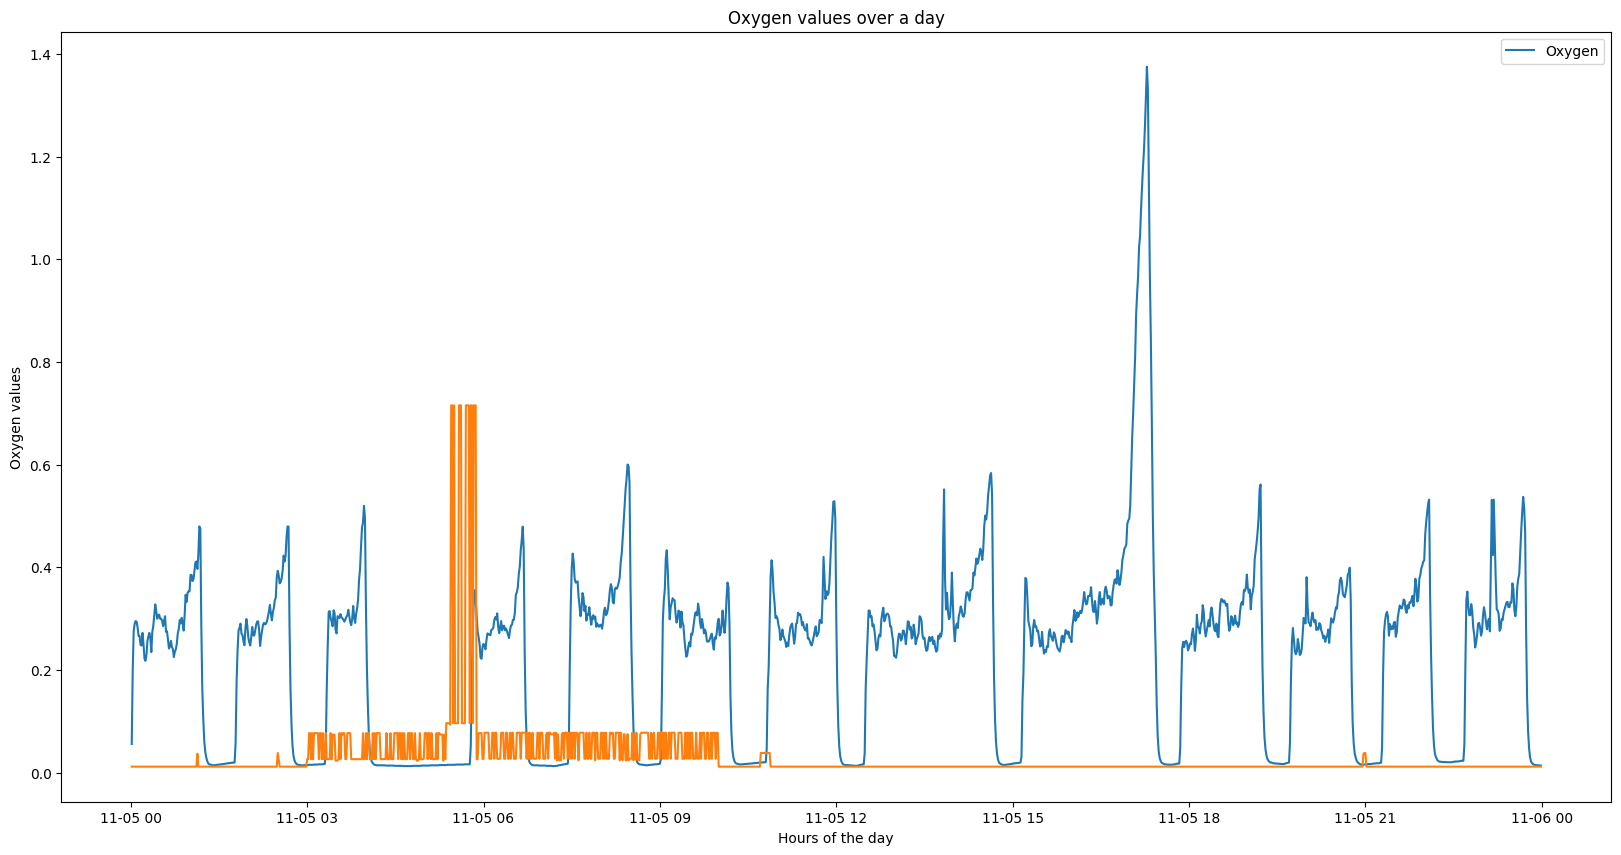

In [ ]:
day = df.loc[(df.index > '2021-11-05') & (df.index < '2021-11-06')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.plot(day.index,day['prediction'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])